<img src='https://as2.ftcdn.net/v2/jpg/08/69/81/05/1000_F_869810518_tVvWV73uvFx8Gkfdl7weCzgCcWzZqvCs.jpg'>

In the previous two notebooks (transfer learning *part 1: feature extraction* and *part 2: fine-tuning*) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

> 🔑 **Note:** You haven't forgotten the machine learning practitioners motto have you? "Experiment, experiment, experiment."

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original Food101 paper's results with 10% of data**.

<img src ='https://camo.githubusercontent.com/8ae41cd33b6beff300dfd42c464ce7d2b65fd4aa7747023c8e151571a139acc5/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30362d6d6c2d73657269616c2d6578706572696d656e746174696f6e2e706e67'>
<i>Machine learning practitioners are serial experimenters. Start small, get a model working, see if your experiments work then gradually scale them up to where you want to go (we're going to be looking at scaling up throughout this notebook).</i>

# What we're going to cover

We're going to go through the follow with TensorFlow:

* Downloading and preparing 10% of the Food101 data (10% of training data)
* Training a feature extraction transfer learning model on 10% of the Food101 training data
* Fine-tuning our feature extraction model
* Saving and loaded our trained model
* Evaluating the performance of our Food Vision model trained on 10% of the training data
  * Finding our model's most wrong predictions
* Making predictions with our Food Vision model on custom images of food

# Import statements

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import os
import random

# Creating helper functions

We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the `helper_functions.py` file from the GitHub repo.

In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/CarlosBIOS/TensorFlow/refs/heads/main/helper_functions.py

--2024-10-26 09:08:10--  https://raw.githubusercontent.com/CarlosBIOS/TensorFlow/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10364 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.12K  --.-KB/s    in 0s      

2024-10-26 09:08:11 (138 MB/s) - ‘helper_functions.py’ saved [10364/10364]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot, make_confusion_matrix

# 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 images.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

# Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [Food Vision preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)).

We download the data as a zip file so we'll use our unzip_data() function to unzip it.

In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-10-26 09:08:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  17.0MB/s    in 1m 41s  

2024-10-26 09:09:52 (15.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lasagna'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in

As before our data comes in the common image classification data format of:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

Let's use the `image_dataset_from_directory()` function to turn our images and labels into a `tf.data.Dataset`, a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [ ]:
IMAGE_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMAGE_SIZE,
                                                                 shuffle=False)  # Quando tivermos a comparar com os true label, para não dar erro ou mal!!

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


> 🔑 **Note:** This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images).

# Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original Food101 paper (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

* A `ModelCheckpoint` callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) `EfficientNetB0` architecture from `tf.keras.applications` as our base model
* A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data
* It seems like a lot but these are all things we've covered before in the Transfer Learning in TensorFlow Part 2: Fine-tuning notebook.

Let's start by creating the `ModelCheckpoint` callback.

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [ ]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"  # Add '.weights.h5' to the end
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True)

Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
], name='data_augmentation')

Beautiful! We'll be able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using `tf.keras.applications.efficientnet.EfficientNetB0` as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a Dense layer.

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_shape')
x = data_augmentation(inputs)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<img src ='https://camo.githubusercontent.com/3854eae8967ef6976a7aa612c154f03d38a260c43073ca9b0d0f09d46ae979d2/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d7264626f75726b652f74656e736f72666c6f772d646565702d6c6561726e696e672f6d61696e2f696d616765732f30362d656666696369656e746e657462302d666561747572652d657874726163746f722d776974682d64656e73652d6c617965722d6f6e2d746f702e706e67'>
<i>A colourful figure of the model we've created with: 224x224 images as input, data augmentation as a layer, EfficientNetB0 as a backbone, an averaging pooling layer as well as dense layer with 10 neurons (same as number of classes we're working with) as output.</i>

Model created. Let's inspect it.

In [ ]:
# Get a summary of our model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_shape (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Looking good! Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model (`EfficientNetb0`) frozen whilst allowing the model to tune its outputs to our custom data.

Time to compile and fit.

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 95s 345ms/step - accuracy: 0.1283 - loss: 4.0896 - val_accuracy: 0.4206 - val_loss: 2.5881
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 333ms/step - accuracy: 0.4120 - loss: 2.6041 - val_accuracy: 0.4853 - val_loss: 2.1409
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 333ms/step - accuracy: 0.4892 - loss: 2.1834 - val_accuracy: 0.5113 - val_loss: 1.9632
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 332ms/step - accuracy: 0.5233 - loss: 1.9760 - val_accuracy: 0.5239 - val_loss: 1.8694
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 331ms/step - accuracy: 0.5445 - loss: 1.8218 - val_accuracy: 0.5341 - val_loss: 1.8147


Woah! It looks like our model is getting some impressive results, but remember, during training our model only evaluated on 15% of the test data. Let's see how it did on the whole test dataset.

In [ ]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.5072 - loss: 1.9191


[1.814677119255066, 0.5341386198997498]

Well it looks like **we just beat our baseline (the results from the original Food101 paper) with 10% of the data**! In under 5-minutes... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves look?

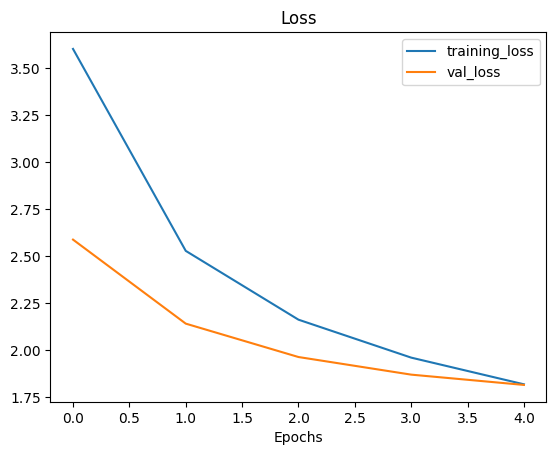

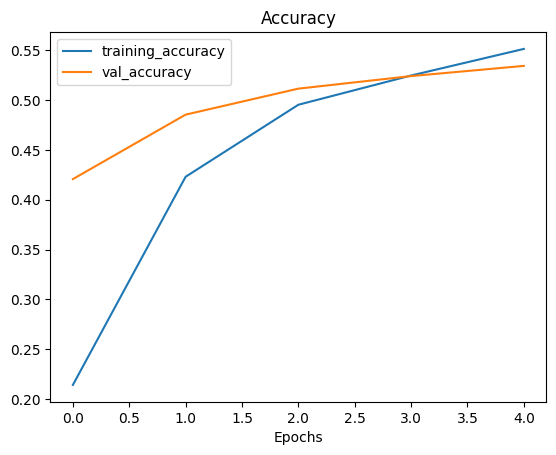

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest?
* **Hint:** ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.

# Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model and what do we have to do every time we make a change to our model?

Recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

Excellent! Time to fine-tune our model.

Another 5 epochs should be enough to see whether any benefits come about (though we could always try more).

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 92s 344ms/step - accuracy: 0.5551 - loss: 1.7960 - val_accuracy: 0.5504 - val_loss: 1.7347
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 331ms/step - accuracy: 0.6169 - loss: 1.5622 - val_accuracy: 0.5569 - val_loss: 1.6971
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 329ms/step - accuracy: 0.6275 - loss: 1.4736 - val_accuracy: 0.5632 - val_loss: 1.6670
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 329ms/step - accuracy: 0.6464 - loss: 1.4017 - val_accuracy: 0.5710 - val_loss: 1.6404
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 78s 328ms/step - accuracy: 0.6669 - loss: 1.3365 - val_accuracy: 0.5749 - val_loss: 1.6229
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 328ms/step - accuracy: 0.6792 - loss: 1.2816 - val_accuracy: 0.5774 - val_loss: 1.6048


Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.

In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 56s 70ms/step - accuracy: 0.5556 - loss: 1.7021


[1.6047528982162476, 0.5773861408233643]

Hmm... it seems like our model got a slight boost from fine-tuning.

We might get a better picture by using our `compare_historys()` function and seeing what the training curves say.

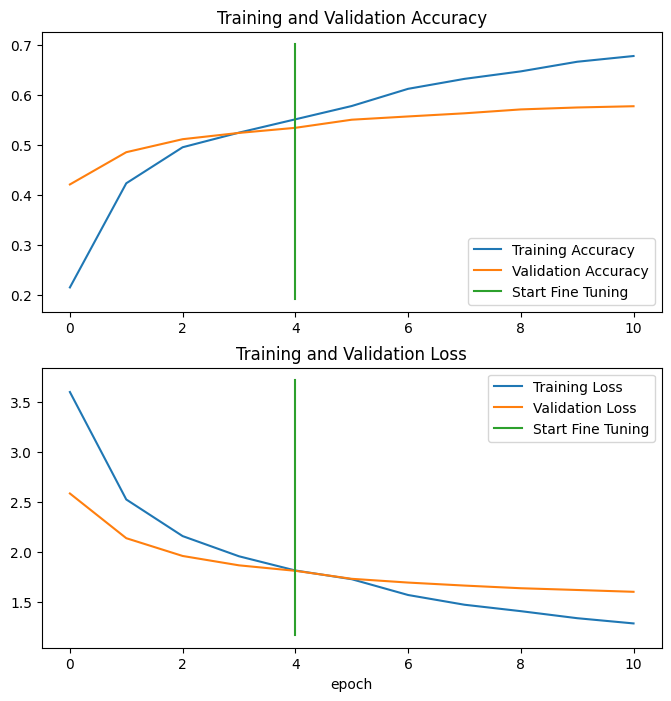

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on ImageNet which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on

# Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

To make sure our loaded model is indead a trained model, let's evaluate its performance on the test dataset

In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.5556 - loss: 1.7021


(1.6047528982162476, 0.5773861408233643)

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 67ms/step


We just passed all of the test images to our model and asked it to make a prediction on what food it thinks is in each.

So if we had 25250 images in the test dataset, how many predictions do you think we should have?

In [ ]:
# What's the shape of our predictions?
pred_probs.shape

(25250, 101)

What we've got is often referred to as a **predictions probability** tensor (or array).

Let's see what the first 10 look like.

In [ ]:
# How do they look?
pred_probs[:10]

array([[5.13683975e-01, 8.26855015e-04, 1.40080228e-01, ...,
        1.27090942e-04, 1.52387237e-03, 2.02522520e-02],
       [8.55552435e-01, 7.71973464e-06, 3.44278314e-03, ...,
        4.86464333e-03, 3.11965005e-06, 2.92302684e-05],
       [3.58519286e-01, 6.40477240e-03, 5.79347694e-03, ...,
        2.20624055e-03, 2.69038865e-04, 2.25924188e-03],
       ...,
       [4.65016514e-01, 2.25330550e-05, 9.68036801e-03, ...,
        5.98399006e-02, 3.22014006e-04, 1.97257177e-04],
       [1.15862407e-01, 2.16225232e-03, 1.15664095e-01, ...,
        1.70973537e-03, 3.16088641e-04, 1.12703152e-03],
       [5.97289145e-01, 1.60638338e-05, 2.65812548e-03, ...,
        1.12178586e-02, 3.87118635e-05, 2.38257390e-03]], dtype=float32)

Alright, it seems like we've got a bunch of tensors of really small numbers, how about we zoom into one of them?

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.13683975e-01 8.26855015e-04 1.40080228e-01 1.57357204e-06
 5.18874594e-06 2.10096514e-05 1.88707770e-03 1.41551602e-04
 3.94477472e-02 1.13099744e-03 1.57233080e-05 1.32704328e-04
 2.55686347e-03 5.52428628e-06 1.31387003e-02 7.22454570e-04
 3.44976841e-04 1.93115789e-03 2.31634971e-04 1.89702132e-05
 2.44271912e-04 1.62814773e-04 2.16845219e-04 5.43910312e-04
 3.10251955e-04 1.11750793e-03 9.45964304e-04 3.09056413e-05
 2.58543082e-02 1.50503963e-03 1.24077942e-05 8.91519478e-04
 2.16628192e-03 2.09868631e-05 1.20614469e-02 4.21376244e-05
 4.63867444e-04 1.17620418e-03 7.86681008e-03 5.95894526e-05
 4.54985246e-04 1.88258025e-04 1.46671711e-03 8.94051846e-06
 1.07636064e-04 6.12697273e-04 8.73542915e-04 7.78530521e-05
 2.31102658e-05 4.02759342e-03 9.38734738e-04 2.67570886e-05
 1.19096220e-01 2.75266636e-03 5.42332509e-06 9.22933873e-03
 4.03374573e-03 1.43507984e-03 1.18360175e-

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax"`)), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probability value, the less the model thinks that the target image is that specific class.

> 🔑 **Note:** Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1). E.g. `pred_probs[0].sum() = 1`.

In [ ]:
pred_probs[0].sum()

0.99999994

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29,  0,  9,  0])

Beautiful! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our `test_data` object (which is in the form of a `tf.data.Dataset`) using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the `argmax()` method to return the index of the label.

> 🔑 **Note:** This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [ ]:
# Note: This might take a minute or so due to unravelling 790(25250/32) batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Nice! Since `test_data` isn't shuffled, the `y_labels` array comes back in the same order as the `pred_classes` array.

The final check is to see how many labels we've got.

In [ ]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

As expected, the number of labels matches the number of images we've got. Time to compare our model's predictions with the ground truth labels.

# Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
# from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5773861386138613

In [ ]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
# import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 2.2095029139634903e-09


Okay, it looks like our `pred_classes` array and `y_labels` arrays are in the right orders.

How about we get a little bit more visual with a confusion matrix?

To do so, we'll use our `make_confusion_matrix` function we created in a previous notebook.

In [ ]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.
# from helper_functions import make_confusion_matrix

Right now our predictions and truth labels are in the form of integers, however, they'll be much easier to understand if we get their actual names. We can do so using the `class_names` attribute on our test_data object.

In [ ]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

101 class names and 25250 predictions and ground truth labels ready to go! Looks like our confusion matrix is going to be a big one!

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

Output hidden; open in https://colab.research.google.com to view.

Woah! Now that's a big confusion matrix. It may look a little daunting at first but after zooming in a little, we can see how it gives us insight into which classes its getting "confused" on.

The good news is, the majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visualually similar, such as predicting `filet_mignon` for instances of `pork_chop` and `chocolate_cake` for instances of `tiramisu`.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's `classification_report()` function.

In [ ]:
# from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.16      0.22       250
           1       0.46      0.71      0.56       250
           2       0.58      0.61      0.59       250
           3       0.83      0.46      0.59       250
           4       0.51      0.43      0.47       250
           5       0.39      0.38      0.39       250
           6       0.70      0.72      0.71       250
           7       0.81      0.71      0.76       250
           8       0.25      0.53      0.34       250
           9       0.35      0.62      0.45       250
          10       0.49      0.41      0.45       250
          11       0.71      0.56      0.63       250
          12       0.74      0.55      0.63       250
          13       0.48      0.55      0.51       250
          14       0.50      0.54      0.52       250
          15       0.45      0.29      0.35       250
          16       0.64      0.48      0.55       250
          17       0.37    

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:

* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3445378151260504,
  'recall': 0.164,
  'f1-score': 0.2222222222222222,
  'support': 250.0},
 '1': {'precision': 0.4609375,
  'recall': 0.708,
  'f1-score': 0.5583596214511041,
  'support': 250.0},
 '2': {'precision': 0.5801526717557252,
  'recall': 0.608,
  'f1-score': 0.59375,
  'support': 250.0},
 '3': {'precision': 0.8333333333333334,
  'recall': 0.46,
  'f1-score': 0.5927835051546392,
  'support': 250.0},
 '4': {'precision': 0.5070422535211268,
  'recall': 0.432,
  'f1-score': 0.46652267818574517,
  'support': 250.0},
 '5': {'precision': 0.39183673469387753,
  'recall': 0.384,
  'f1-score': 0.3878787878787879,
  'support': 250.0},
 '6': {'precision': 0.7042801556420234,
  'recall': 0.724,
  'f1-score': 0.7140039447731755,
  'support': 250.0},
 '7': {'precision': 0.8127853881278538,
  'recall': 0.712,
  'f1-score': 0.7590618336886994,
  'support': 250.0},
 '8': {'precision': 0.2509505703422053,
  'recall': 0.528,
  'f1-score': 0.3402061855670103,
  'support': 2

Alright, there's still a fair few values here, how about we narrow down?

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.2222222222222222,
 'baby_back_ribs': 0.5583596214511041,
 'baklava': 0.59375,
 'beef_carpaccio': 0.5927835051546392,
 'beef_tartare': 0.46652267818574517,
 'beet_salad': 0.3878787878787879,
 'beignets': 0.7140039447731755,
 'bibimbap': 0.7590618336886994,
 'bread_pudding': 0.3402061855670103,
 'breakfast_burrito': 0.4492753623188406,
 'bruschetta': 0.4458874458874459,
 'caesar_salad': 0.6280623608017817,
 'cannoli': 0.6330275229357798,
 'caprese_salad': 0.5139664804469274,
 'carrot_cake': 0.5182341650671785,
 'ceviche': 0.3526570048309179,
 'cheese_plate': 0.55,
 'cheesecake': 0.41535776614310643,
 'chicken_curry': 0.4491362763915547,
 'chicken_quesadilla': 0.5742092457420924,
 'chicken_wings': 0.7003484320557491,
 'chocolate_cake': 0.49583333333333335,
 'chocolate_mousse': 0.3612167300380228,
 'churros': 0.7342342342342343,
 'clam_chowder': 0.7148760330578512,
 'club_sandwich': 0.6640926640926641,
 'crab_cakes': 0.3815261044176707,
 'creme_brulee': 0.7335907335907336,


Looking good!

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion?

In [ ]:
# Turn f1-scores into dataframe for visualization
# import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33    edamame  0.952756
63   macarons  0.834821
75        pho  0.826176
64  miso_soup  0.818533
86    sashimi  0.814532

Now we're talking! Let's finish it off with a nice horizontal bar chart.

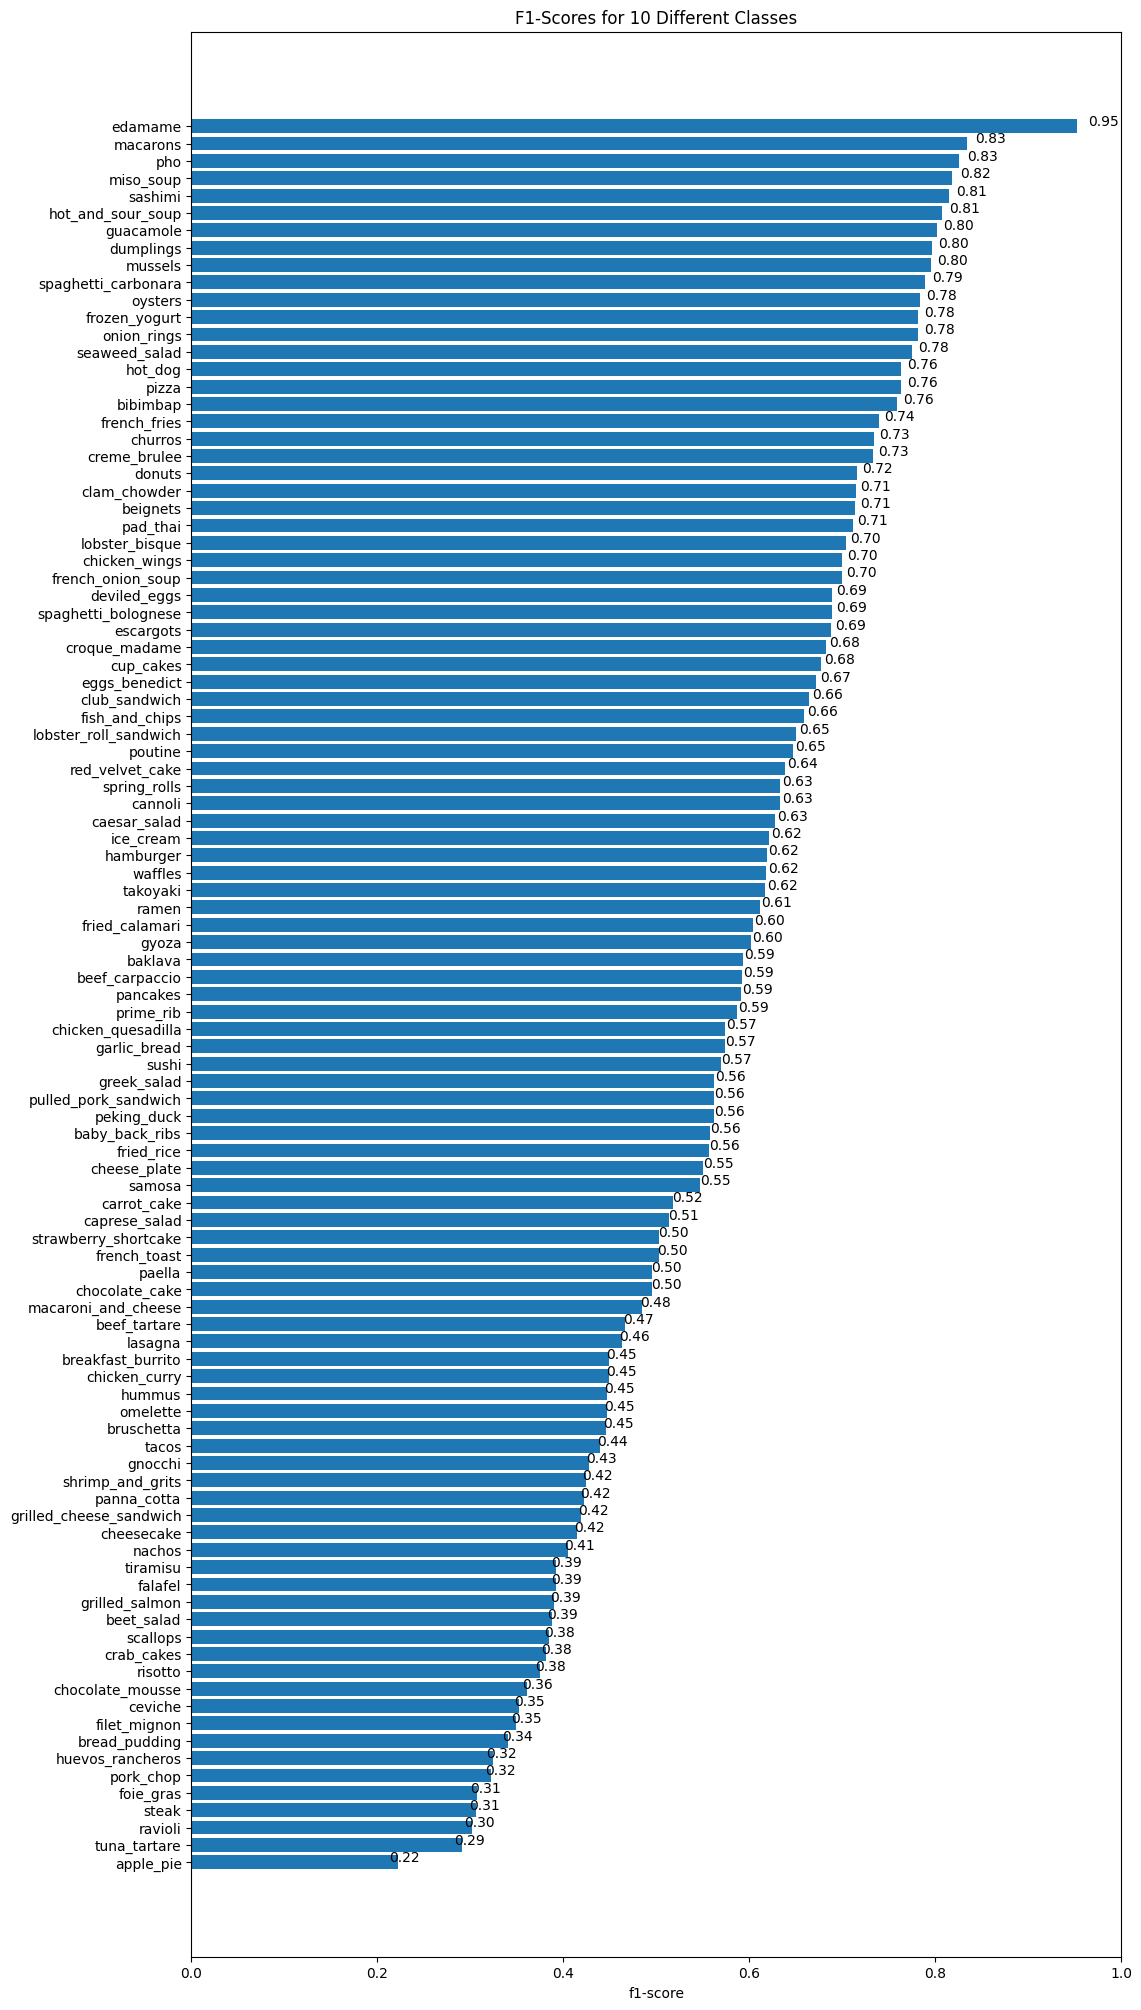

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

Now that's a good looking graph! I mean, the text positioning could be improved a little but it'll do for now.

Can you see how visualizing our model's predictions gives us a completely new insight into its performance?

A few moments ago we only had an accuracy score but now we've got an indiciation of how well our model is performing on a class by class basis.

It seems like our model performs fairly poorly on classes like `apple_pie` and `foie_gras` while for classes like `edamame` and `macarons` the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

> 🛠 **Exercise:** Visualize some of the most poor performing classes, do you notice any trends among them?

# Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:

* Read in a target image filepath using `tf.io.read_file()`.
* Turn the image into a Tensor using `tf.io.decode_image()`.
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using `tf.image.resize()`.
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [ ]:
# Its the same that we have in the file helper_functions.py
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Image loading and preprocessing function ready.

Now let's write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


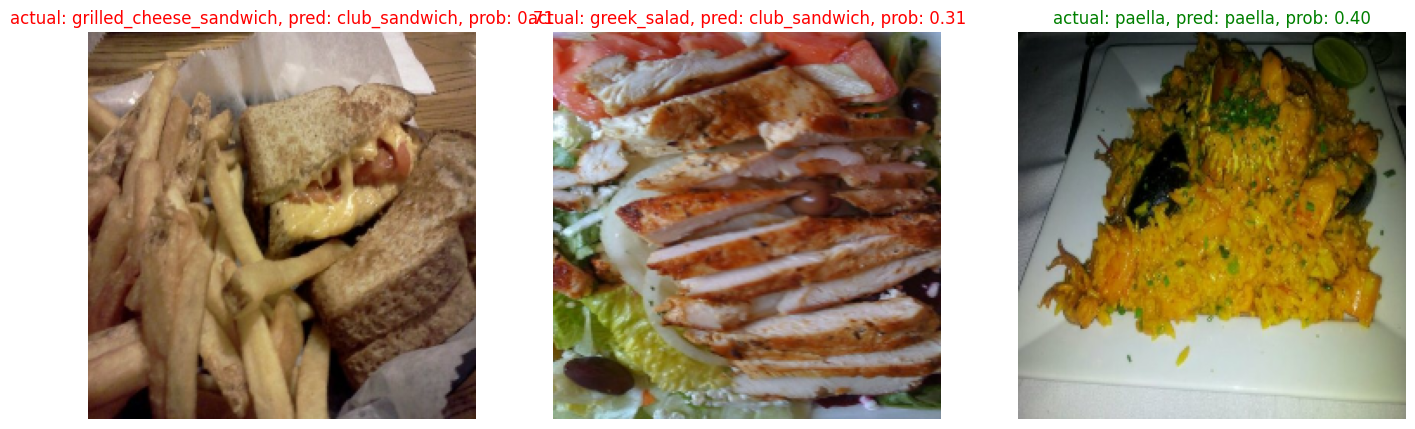

In [ ]:
# Make preds on a series of random images
# import os
# import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

After going through enough random samples, it starts to become clear that the model tends to make far worse predictions on classes which are visually similar such as `baby_back_ribs` getting mistaken as `steak` and vice versa.

# Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the `list_files()` method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  * **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10], len(filepaths)

([b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
  b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
  b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
  b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
  b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
  b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
  b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
  b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
  b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
  b'101_food_classes_10_percent/test/apple_pie/1113017.jpg'],
 25250)

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:

* Their ground truth labels (`y_labels`).
* The class the model predicted (`pred_classes`).
* The maximum prediction probabilitity value (`pred_probs.max(axis=1)`).
* The ground truth class names.
* The predicted class names.

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.513684        apple_pie        apple_pie  
1   0.855552        apple_pie        apple_pie  
2   0.358519        apple_pie        apple_pie  
3   0.173354        apple_pie   fish_and_chips  
4   0.352630        apple_pie    bread_pudding

Nice! How about we make a simple column telling us whether or not the prediction is right or wrong?

In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.513684        apple_pie        apple_pie          True  
1   0.855552        apple_pie        apple_pie          True  
2   0.358519        apple_pie        apple_pie          True  
3   0.173354        apple_pie   fish_and_chips         False  
4   0.352630        apple_pie    bread_pudding         False

And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
22     b'101_food_classes_10_percent/test/apple_pie/1...       0     100   
17816  b'101_food_classes_10_percent/test/paella/1762...      71      70   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
10947  b'101_food_classes_10_percent/test/fried_calam...      43      68   
12487  b'101_food_classes_10_percent/test/grilled_che...      49      25   
22684  b'101_food_classes_10_percent/test/spaghetti_b...      90      91   
13094  b'101_food_classes_10_percent/test/gyoza/24308...      52      32   
5849   b'101_food_classes_10_percent/test/churros/254...      23      68   
14062  b'101_food_classes_10_percent/test/huevos_ranc...      56      28   
7858   b'101_food_classes_10_percent/test/donuts/2564...      31       6   
22511  b'101_food_classes_10_percent/test/spaghetti_b...      90      78   
23935  b'101_food_classes_10_percent/test/sushi/46797...      95      86   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
14809  b'101_food_classes_10_percent/test/lasagna/215...      59      27   
21913  b'101_food_classes_10_percent/test/scallops/34...      87       5   

       pred_conf         y_true_classname     y_pred_classname  pred_correct  
23631   0.999300     strawberry_shortcake      red_velvet_cake         False  
10847   0.997371           fried_calamari          onion_rings         False  
23797   0.995216                    sushi              sashimi         False  
22      0.993844                apple_pie              waffles         False  
17816   0.989525                   paella             pad_thai         False  
15826   0.989395                 macarons            cup_cakes         False  
18001   0.988384                 pancakes             omelette         False  
10854   0.987973           fried_calamari          onion_rings         False  
10947   0.985752           fried_calamari          onion_rings         False  
12487   0.984384  grilled_cheese_sandwich        club_sandwich         False  
22684   0.984208      spaghetti_bolognese  spaghetti_carbonara         False  
13094   0.982334                    gyoza            dumplings         False  
5849    0.981749                  churros          onion_rings         False  
14062   0.980608         huevos_rancheros        croque_madame         False  
7858    0.980381                   donuts             beignets         False  
22511   0.979790      spaghetti_bolognese              poutine         False  
23935   0.977907                    sushi              sashimi         False  
5114    0.977555            chicken_wings       fish_and_chips         False  
14809   0.977474                  lasagna         creme_brulee         False  
21913   0.977271                 scallops           beet_salad         False

Very interesting... just by comparing the ground truth classname (`y_true_classname`) and the prediction classname column (`y_pred_classname`), do you notice any trends?

It might be easier if we visualize them.

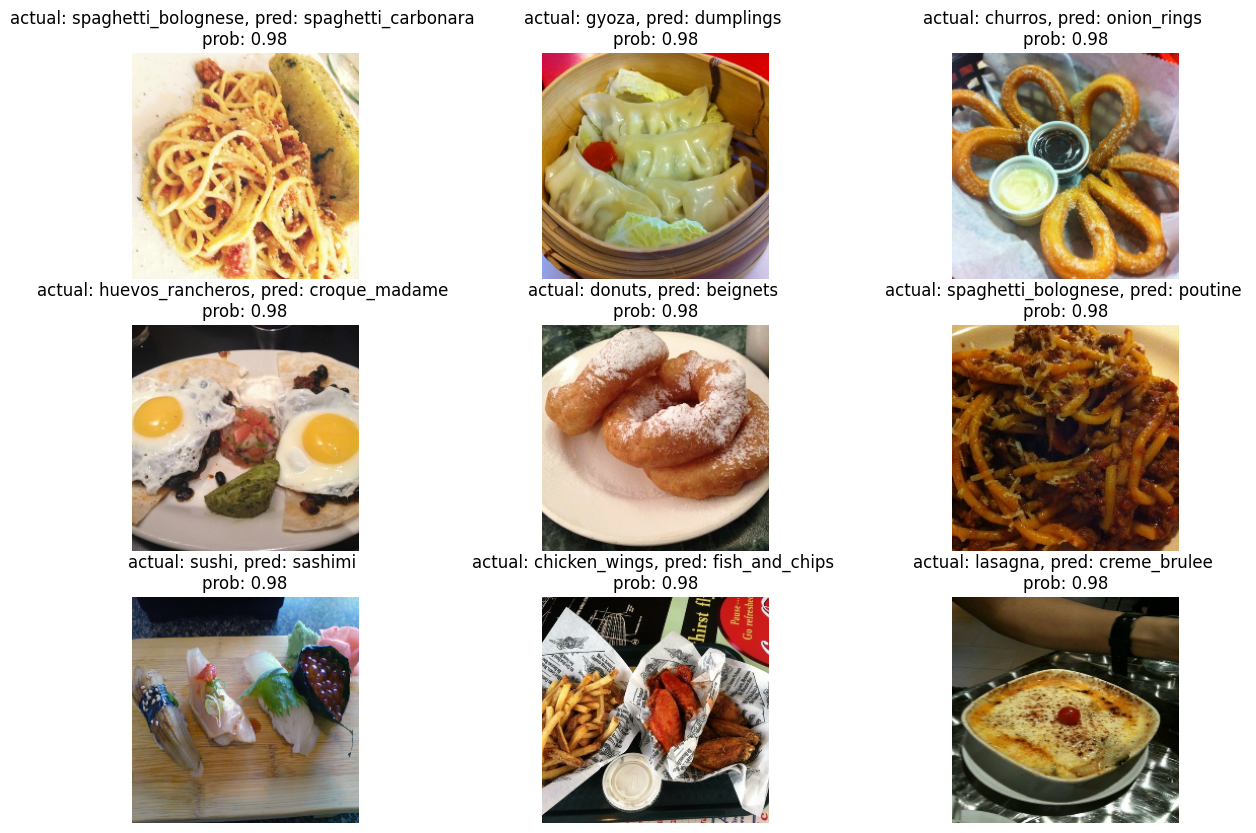

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

Going through the model's most wrong predictions can usually help figure out a couple of things:

* **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as [active learning](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/).
* **Could more samples be collected?** - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

# Test out the big dog model on test images as well as custom images of food

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

For this you might want to upload your own images to Google Colab or by putting them in a folder you can load into the notebook.

In my case, I've prepared my own small dataset of six or so images of various foods.

Let's download them and unzip them.

In [57]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-10-26 09:42:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.2’

custom_food_images. 100%[===================>]  12.58M  7.52MB/s    in 1.7s    

2024-10-26 09:42:57 (7.52 MB/s) - ‘custom_food_images.zip.2’ saved [13192985/13192985]



In [59]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


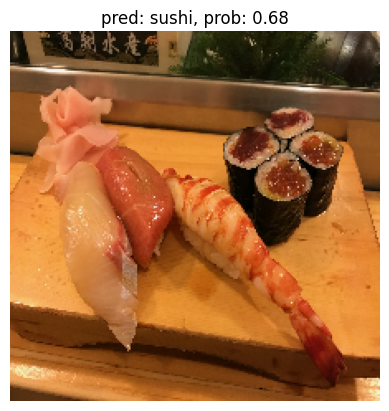

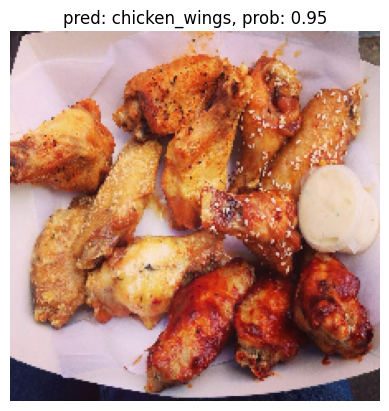

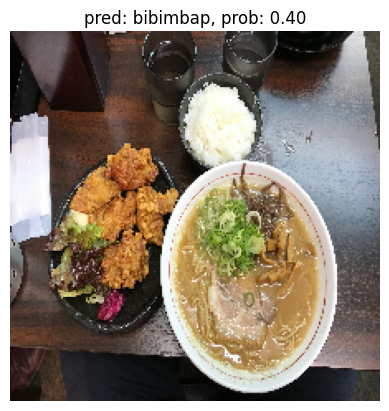

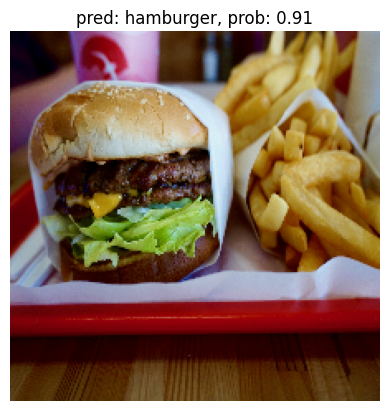

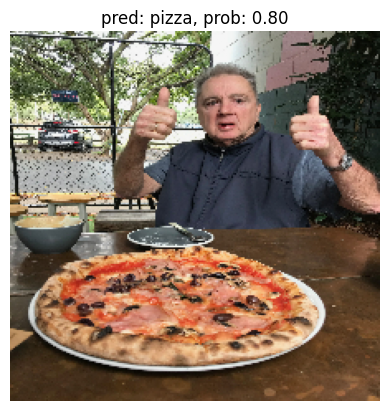

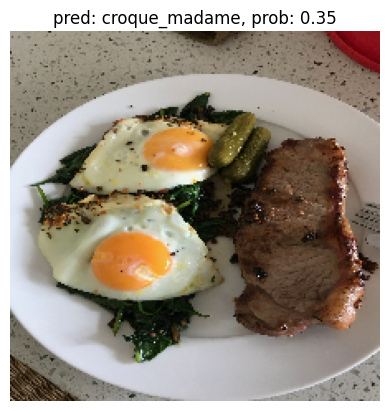

In [60]:
# Make predictions on custom food images
for img_path in custom_food_images:
  # Load and preprocess the image, ensuring it's in RGB format
  img = load_and_prep_image(img_path, scale=False)
  img = img[:,:,:3] # Select only the first 3 channels (RGB)

  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label

  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Two thumbs up! How cool is that?! Our Food Vision model has come to life!

Seeing a machine learning model work on a premade test dataset is cool but seeing it work on your own data is mind blowing.

And guess what... our model got these incredible results (10%+ better than the baseline) with only 10% of the training images.

I wonder what would happen if we trained a model with all of the data (100% of the training data from Food101 instead of 10%)?

**Hint:** that's your task in the next notebook.

# 🛠 Exercises

1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook).
3. Which method is better? Recreate our first model (the feature extraction model) with `mixed_precision` turned on.
* Does it make the model train faster?
* Does it effect the accuracy or performance of our model?
* What's the advatanges of using `mixed_precision` training?

# Extra-curriculum

* Spend 15-minutes reading up on the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping). What does it do? How could we use it in our model training?
* Spend an hour reading about Streamlit. What does it do? How might you integrate some of the things we've done in this notebook in a Streamlit app?